# **This script is used for the following:**
1. to explore the data, remove duplicates, and remove missing values (if applicable.)
2. to create a population dataframe consisting of all the image filenames and labels
3. to visualize distribution of labels and day phases
4. to wrangle the data such as checking for NAs, deleting duplicates, merging annotations with images, re-coding day phases, removing 'cannot say' images from population

In [1]:
import os
from os import listdir
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from tensorflow.keras.preprocessing import image
import re
import datetime
import pandas as pd
import glob
from collections import Counter
from tqdm import tqdm
import shutil
import cv2

In [2]:
%matplotlib inline

## **Load annotation file and make dataframe**

In [3]:
annotation_dir = '/home/ubuntu/michael/my_pickles/'
annotation_file = 'allAnnotations20210601v4.pkl'

In [4]:
annotation_df = pd.read_pickle(annotation_dir + annotation_file)

In [5]:
annotation_df

,filepath,label,day_phase,filename
0,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A5...,Fog,0,A5-HM92-ID13771_20190427_0101.jpg
1,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A9...,No Fog,0,A9-HM462-ID12800_20190811_2310.jpg
2,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A5...,No Fog,0,A5-HM17-ID11089_20190429_2151.jpg
3,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A1...,No Fog,0,A16-HM231-ID12256_20190810_0020.jpg
4,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A4...,Cannot Say,0,A4-HM81-ID11066_20190810_2340.jpg
...,...,...,...,...
46437,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A2...,No Fog,1,A27-HM582-ID10977_20170913_0931.jpg
46438,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A2...,No Fog,1,A2-HM765-ID10913_20170907_0800.jpg
46439,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A1...,Cannot Say,0,A15-HM793-ID12043_20170915_0131.jpg
46440,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A9...,Cannot Say,0,A9-HM402-ID11221_20191230_0021.jpg


In [6]:
# check for missing values
annotation_df.isnull().any()

filepath     False
label        False
day_phase    False
filename     False
dtype: bool

In [7]:
# check for duplicates
duplicates = annotation_df[annotation_df.duplicated(['filename'])]
duplicates

,filepath,label,day_phase,filename
413,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A9...,No Fog,0,A9-HM474-ID12809_20190430_2151.jpg
682,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A9...,No Fog,0,A9-HM467-ID12803_20190811_0050.jpg
754,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A4...,No Fog,0,A4-HM449-ID12092_20190426_2241.jpg
824,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A5...,No Fog,0,A50-HM1930-ID11543_20190811_2310.jpg
846,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A4...,No Fog,0,A4-HM449-ID12003_20190501_0031.jpg
...,...,...,...,...
46277,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A1...,No Fog,10,A16-HM256-ID12261_20191230_0751.jpg
46415,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A2...,No Fog,0,A28-HM1954-ID11818_20191230_0340.jpg
46416,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A9...,No Fog,1,A9-HM312-ID11179_20200121_1600.jpg
46430,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A5...,No Fog,1,A50-HM1873-ID11522_20200121_1010.jpg


In [8]:
# given that there are duplicates in the annotaitons_df, delete them
annotation_df = annotation_df.drop_duplicates(subset=['filename'])
len(annotation_df)

54213

## **Load image files and make dataframe**

In [9]:
# point to source directory where all NL images are stored
src_dir = '/home/ubuntu/backup_images_2/images01062021'
#src_dir = '/home/ubuntu/michael/nl_images/images_data' # this directory has all the images to date (1-June-2021)

In [10]:
# to select all files in directory ending in .jpg (these are the images)
img_filenames = []
img_filenames = [filename for filename in os.listdir(src_dir) if filename.endswith('.jpg')]
len(img_filenames) #54213 images

54213

In [11]:
# create filepaths for NL images
img_filepath_list = []
for file in os.listdir(src_dir):
    if file.endswith('.jpg'):
        img_filepath = os.path.join(src_dir + '/' + file)
        img_filepath_list.append(img_filepath)
len(img_filepath_list)

54213

In [12]:
# create dataframe to store file information
image_df = pd.DataFrame()
image_df['filepath'] = img_filepath_list
image_df['filename'] = img_filenames
image_df

,filepath,filename
0,/home/ubuntu/backup_images_2/images01062021/A9...,A9-HM448-ID12793_20180920_1030.jpg
1,/home/ubuntu/backup_images_2/images01062021/A1...,A1-HM63-ID12964_20170906_2250.jpg
2,/home/ubuntu/backup_images_2/images01062021/A1...,A15-HM791-ID12042_20170912_2031.jpg
3,/home/ubuntu/backup_images_2/images01062021/A2...,A28-HM1989-ID11817_20170917_0041.jpg
4,/home/ubuntu/backup_images_2/images01062021/A9...,A9-HM402-ID11221_20170914_0121.jpg
...,...,...
54208,/home/ubuntu/backup_images_2/images01062021/A9...,A9-HM478-ID12826_20200122_1220.jpg
54209,/home/ubuntu/backup_images_2/images01062021/A9...,A9-HM463-ID12801_20190810_0000.jpg
54210,/home/ubuntu/backup_images_2/images01062021/A2...,A27-HM662-ID10964_20180920_1410.jpg
54211,/home/ubuntu/backup_images_2/images01062021/A5...,A50-HM1864-ID11640_20200101_0341.jpg


In [13]:
# check for missing values
image_df.isnull().any()

filepath    False
filename    False
dtype: bool

In [14]:
# check for duplicates
duplicates = image_df[image_df.duplicated(['filename'])]
len(duplicates) #0

0

## **Merge dataframes inner join**

In [15]:
merged_df = pd.merge(annotation_df, image_df, on = 'filename', how = 'inner', indicator = True)
len(merged_df) #54213

54213

In [16]:
merged_df.head()

,filepath_x,label,day_phase,filename,filepath_y,_merge
0,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A5...,Fog,0,A5-HM92-ID13771_20190427_0101.jpg,/home/ubuntu/backup_images_2/images01062021/A5...,both
1,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A9...,No Fog,0,A9-HM462-ID12800_20190811_2310.jpg,/home/ubuntu/backup_images_2/images01062021/A9...,both
2,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A5...,No Fog,0,A5-HM17-ID11089_20190429_2151.jpg,/home/ubuntu/backup_images_2/images01062021/A5...,both
3,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A1...,No Fog,0,A16-HM231-ID12256_20190810_0020.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,both
4,/nas-research.knmi.nl/sensordata/CAMERA/RWS/A4...,Cannot Say,0,A4-HM81-ID11066_20190810_2340.jpg,/home/ubuntu/backup_images_2/images01062021/A4...,both


In [17]:
merged_df = merged_df.drop(['filepath_x', '_merge'], axis = 1)
merged_df = merged_df.rename(columns = {'filepath_y':'filepath'})
merged_df

,label,day_phase,filename,filepath
0,Fog,0,A5-HM92-ID13771_20190427_0101.jpg,/home/ubuntu/backup_images_2/images01062021/A5...
1,No Fog,0,A9-HM462-ID12800_20190811_2310.jpg,/home/ubuntu/backup_images_2/images01062021/A9...
2,No Fog,0,A5-HM17-ID11089_20190429_2151.jpg,/home/ubuntu/backup_images_2/images01062021/A5...
3,No Fog,0,A16-HM231-ID12256_20190810_0020.jpg,/home/ubuntu/backup_images_2/images01062021/A1...
4,Cannot Say,0,A4-HM81-ID11066_20190810_2340.jpg,/home/ubuntu/backup_images_2/images01062021/A4...
...,...,...,...,...
54208,No Fog,1,A16-HM211-ID71681_20170907_1200.jpg,/home/ubuntu/backup_images_2/images01062021/A1...
54209,No Fog,1,A27-HM582-ID10977_20170913_0931.jpg,/home/ubuntu/backup_images_2/images01062021/A2...
54210,No Fog,1,A2-HM765-ID10913_20170907_0800.jpg,/home/ubuntu/backup_images_2/images01062021/A2...
54211,Cannot Say,0,A15-HM793-ID12043_20170915_0131.jpg,/home/ubuntu/backup_images_2/images01062021/A1...


## **Get distributions of labels and day phase**

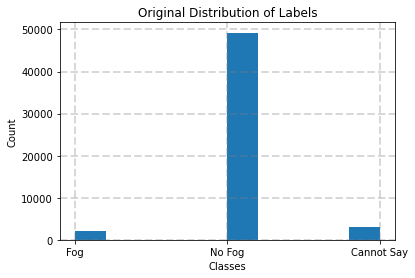

In [18]:
# visualize the distribution of labels ('Fog', 'No Fog', 'Cannot Say')
fig = plt.figure()
plt.hist(merged_df.label)
plt.title('Original Distribution of Labels')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.grid(color = 'grey', alpha = 0.3, linestyle = '--', linewidth = 2)
#plt.show()
plt.savefig('/home/ubuntu/michael/script_images/dist_labels_org.jpg')

In [33]:
cannot_say = merged_df[merged_df['label'] == "Cannot Say"]
cannot_say # 2968 samples with label 'Cannot Say'

,label,day_phase,filename,filepath
4,Cannot Say,0,A4-HM81-ID11066_20190810_2340.jpg,/home/ubuntu/backup_images_2/images01062021/A4...
18,Cannot Say,0,A4-HM448-ID12002_20190504_2350.jpg,/home/ubuntu/backup_images_2/images01062021/A4...
22,Cannot Say,0,A4-HM449-ID12092_20190427_2151.jpg,/home/ubuntu/backup_images_2/images01062021/A4...
24,Cannot Say,0,A9-HM477-ID12827_20190429_2321.jpg,/home/ubuntu/backup_images_2/images01062021/A9...
27,Cannot Say,0,A4-HM449-ID12003_20190810_0010.jpg,/home/ubuntu/backup_images_2/images01062021/A4...
...,...,...,...,...
53367,Cannot Say,1,A27-HM587-ID10975_20170906_1600.jpg,/home/ubuntu/backup_images_2/images01062021/A2...
53380,Cannot Say,1,A1-HM57-ID12957_20170907_1200.jpg,/home/ubuntu/backup_images_2/images01062021/A1...
53500,Cannot Say,0,A4-HM440-ID12000_20170912_2121.jpg,/home/ubuntu/backup_images_2/images01062021/A4...
53589,Cannot Say,1,A50-HM1841-ID11511_20170908_0800.jpg,/home/ubuntu/backup_images_2/images01062021/A5...


In [34]:
# remove images that are labeled with "cannot say"
merged_df.drop(merged_df[merged_df['label'] == "Cannot Say"].index, inplace = True)
len(merged_df)

51245

In [35]:
# get overview of labels after removal
merged_df.label.value_counts()

No Fog    49230
Fog        2015
Name: label, dtype: int64

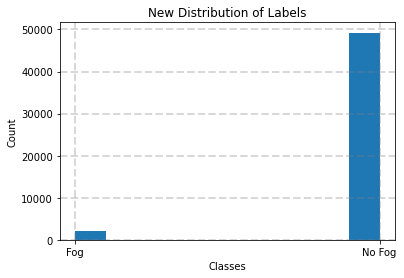

In [39]:
# visualize the distribution of labels ('Fog', 'No Fog', 'Cannot Say')
plt.hist(merged_df.label)
plt.title('New Distribution of Labels')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.grid(color = 'grey', alpha = 0.3, linestyle = '--', linewidth = 2)
plt.savefig('/home/ubuntu/michael/script_images/dist_labels_new.jpg')
plt.show()

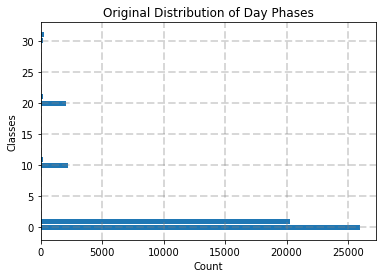

In [24]:
# original distribution of day phase
y = merged_df.day_phase.unique() #array(['1', '0', '20', '10', '30', '31', '11', '21'], dtype=object)
x = merged_df.day_phase.value_counts() # counter per category
plt.barh(y, x)
plt.xlabel('Count')
plt.ylabel('Classes')
plt.title('Original Distribution of Day Phases')
plt.grid(color = 'grey', alpha = 0.3, linestyle = '--', linewidth = 2)
plt.savefig('/home/ubuntu/michael/script_images/dist_labels_new.jpg')
plt.show()

In [40]:
# 0;"night" = 20313
# 1;"day" = 25960
# 10;"civil dawn" = 2068
# 11;"civil dusk" = 157
# 20;"nautical dawn" = 2190
# 21;"nautical dusk" = 143
# 30;"astronomical dawn" = 199
# 31;"astronomical dusk" = 215

In [41]:
# define a function to recode day_phase to human meaningful
def phaseChange(row):
    if row['day_phase'] == 0:
        value = 'Night'
    elif row['day_phase'] == 1:
        value = 'Day'
    elif row['day_phase'] == 10:
        value = 'Civil Dawn'
    elif row['day_phase'] == 11:
        value = 'Civil Dusk'
    elif row['day_phase'] == 20:
        value = 'Nautical Dawn'
    elif row['day_phase'] == 21:
        value = 'Nautical Dusk'
    elif row['day_phase'] == 30:
        value = 'Astronomical Dawn'
    else:
        value = 'Astronomical Dusk'
    return value

In [42]:
# call function and apply to all values in new_phase column of dataframe
merged_df['day_label'] = merged_df.apply(phaseChange, axis=1)
merged_df

,label,day_phase,filename,filepath,day_label
0,Fog,0,A5-HM92-ID13771_20190427_0101.jpg,/home/ubuntu/backup_images_2/images01062021/A5...,Night
1,No Fog,0,A9-HM462-ID12800_20190811_2310.jpg,/home/ubuntu/backup_images_2/images01062021/A9...,Night
2,No Fog,0,A5-HM17-ID11089_20190429_2151.jpg,/home/ubuntu/backup_images_2/images01062021/A5...,Night
3,No Fog,0,A16-HM231-ID12256_20190810_0020.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Night
5,No Fog,0,A1-HM65-ID12966_20190427_2301.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Night
...,...,...,...,...,...
54207,No Fog,0,A1-HM61-ID12961_20191203_0000.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Night
54208,No Fog,1,A16-HM211-ID71681_20170907_1200.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Day
54209,No Fog,1,A27-HM582-ID10977_20170913_0931.jpg,/home/ubuntu/backup_images_2/images01062021/A2...,Day
54210,No Fog,1,A2-HM765-ID10913_20170907_0800.jpg,/home/ubuntu/backup_images_2/images01062021/A2...,Day


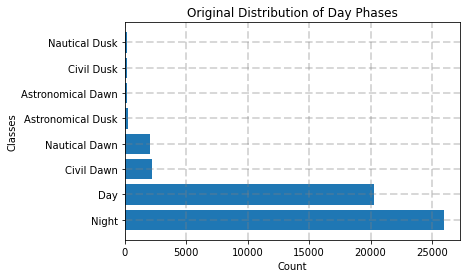

In [43]:
# original distribution of day phase
y = merged_df.day_label.unique() #array(['1', '0', '20', '10', '30', '31', '11', '21'], dtype=object)
x = merged_df.day_label.value_counts() # counter per category
plt.barh(y, x)
plt.xlabel('Count')
plt.ylabel('Classes')
plt.title('Original Distribution of Day Phases')
plt.grid(color = 'grey', alpha = 0.3, linestyle = '--', linewidth = 2)
plt.savefig('/home/ubuntu/michael/script_images/dist_phases_org.jpg')
plt.show()

In [44]:
# dcollapse subgroups into broad day or night groups
def new_phaseChange(row):
    if row['day_phase'] == 0:
        value = 'Night'
    elif row['day_phase'] == 1:
        value = 'Day'
    elif row['day_phase'] == 10:
        value = 'Day'
    elif row['day_phase'] == 11:
        value = 'Day'
    elif row['day_phase'] == 20:
        value = 'Night'
    elif row['day_phase'] == 21:
        value = 'Night'
    elif row['day_phase'] == 30:
        value = 'Night'
    else:
        value = 'Night'
    return value

In [45]:
# call function and apply to all values in new_phase column of dataframe
merged_df['phase'] = merged_df.apply(new_phaseChange, axis=1)
merged_df

,label,day_phase,filename,filepath,day_label,phase
0,Fog,0,A5-HM92-ID13771_20190427_0101.jpg,/home/ubuntu/backup_images_2/images01062021/A5...,Night,Night
1,No Fog,0,A9-HM462-ID12800_20190811_2310.jpg,/home/ubuntu/backup_images_2/images01062021/A9...,Night,Night
2,No Fog,0,A5-HM17-ID11089_20190429_2151.jpg,/home/ubuntu/backup_images_2/images01062021/A5...,Night,Night
3,No Fog,0,A16-HM231-ID12256_20190810_0020.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Night,Night
5,No Fog,0,A1-HM65-ID12966_20190427_2301.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Night,Night
...,...,...,...,...,...,...
54207,No Fog,0,A1-HM61-ID12961_20191203_0000.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Night,Night
54208,No Fog,1,A16-HM211-ID71681_20170907_1200.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Day,Day
54209,No Fog,1,A27-HM582-ID10977_20170913_0931.jpg,/home/ubuntu/backup_images_2/images01062021/A2...,Day,Day
54210,No Fog,1,A2-HM765-ID10913_20170907_0800.jpg,/home/ubuntu/backup_images_2/images01062021/A2...,Day,Day


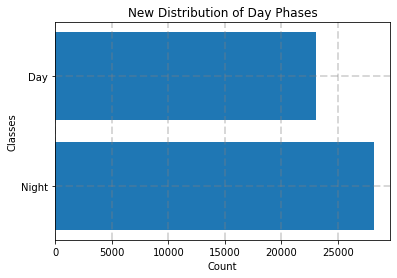

In [46]:
# original distribution of day phase
y = merged_df.phase.unique() #array(['1', '0', '20', '10', '30', '31', '11', '21'], dtype=object)
x = merged_df.phase.value_counts() # counter per category
plt.xlabel('Count')
plt.ylabel('Classes')
plt.title('New Distribution of Day Phases')
plt.barh(y,x)
plt.grid(color = 'grey', alpha = 0.3, linestyle = '--', linewidth = 2)
plt.savefig('/home/ubuntu/michael/script_images/dist_phases_new.jpg')
plt.show()

In [48]:
# get overview of labels after removal
merged_df.phase.value_counts()

Day      28185
Night    23060
Name: phase, dtype: int64

In [49]:
merged_df = merged_df.drop(['day_label'], axis = 1)
merged_df.head()

,label,day_phase,filename,filepath,phase
0,Fog,0,A5-HM92-ID13771_20190427_0101.jpg,/home/ubuntu/backup_images_2/images01062021/A5...,Night
1,No Fog,0,A9-HM462-ID12800_20190811_2310.jpg,/home/ubuntu/backup_images_2/images01062021/A9...,Night
2,No Fog,0,A5-HM17-ID11089_20190429_2151.jpg,/home/ubuntu/backup_images_2/images01062021/A5...,Night
3,No Fog,0,A16-HM231-ID12256_20190810_0020.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Night
5,No Fog,0,A1-HM65-ID12966_20190427_2301.jpg,/home/ubuntu/backup_images_2/images01062021/A1...,Night


In [50]:
merged_df = merged_df[['filename', 'label', 'day_phase', 'phase', 'filepath']]
merged_df

,filename,label,day_phase,phase,filepath
0,A5-HM92-ID13771_20190427_0101.jpg,Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A5...
1,A9-HM462-ID12800_20190811_2310.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A9...
2,A5-HM17-ID11089_20190429_2151.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A5...
3,A16-HM231-ID12256_20190810_0020.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A1...
5,A1-HM65-ID12966_20190427_2301.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A1...
...,...,...,...,...,...
54207,A1-HM61-ID12961_20191203_0000.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A1...
54208,A16-HM211-ID71681_20170907_1200.jpg,No Fog,1,Day,/home/ubuntu/backup_images_2/images01062021/A1...
54209,A27-HM582-ID10977_20170913_0931.jpg,No Fog,1,Day,/home/ubuntu/backup_images_2/images01062021/A2...
54210,A2-HM765-ID10913_20170907_0800.jpg,No Fog,1,Day,/home/ubuntu/backup_images_2/images01062021/A2...


In [51]:
# assign merged_df to nl_df for clarity
nl_df = merged_df
nl_df

,filename,label,day_phase,phase,filepath
0,A5-HM92-ID13771_20190427_0101.jpg,Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A5...
1,A9-HM462-ID12800_20190811_2310.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A9...
2,A5-HM17-ID11089_20190429_2151.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A5...
3,A16-HM231-ID12256_20190810_0020.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A1...
5,A1-HM65-ID12966_20190427_2301.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A1...
...,...,...,...,...,...
54207,A1-HM61-ID12961_20191203_0000.jpg,No Fog,0,Night,/home/ubuntu/backup_images_2/images01062021/A1...
54208,A16-HM211-ID71681_20170907_1200.jpg,No Fog,1,Day,/home/ubuntu/backup_images_2/images01062021/A1...
54209,A27-HM582-ID10977_20170913_0931.jpg,No Fog,1,Day,/home/ubuntu/backup_images_2/images01062021/A2...
54210,A2-HM765-ID10913_20170907_0800.jpg,No Fog,1,Day,/home/ubuntu/backup_images_2/images01062021/A2...


In [52]:
# save NL_image dataframe to pickle file
nl_df.to_pickle('/home/ubuntu/michael/my_pickles/NL_image_df_.pkl') 